### Control Lab equipment remotely
* Sun EC13 temperature chamber
* CAEN N6724 digitizer
* CAEN N14171HV supply

In [46]:
# setup
import sys
CRANEPATH = '/opt/cranelab/CraneLab-build/'
CRANEPATH = '/home/achim/gaps/CraneLab/build'
if sys.path[-1] != CRANEPATH:
    sys.path.append(CRANEPATH)

import numpy as np
from skippylab.instruments.powersupplies import CAENN1471HV
from skippylab.instruments.climate_chambers import SunChamber
from skippylab.controllers import PrologixUsbGPIBController, ZMQController
from skippylab.controllers import SimpleSocketController
from skippylab.controllers import TelnetController

from skippylab.instruments.patchpannels import Cytec


In [59]:
patchp = Cytec(TelnetController("192.168.1.7", 8081))

In [48]:
patchp.get_current_settings()
#patchp._controller.write(" ifconfig 192.168.1.7 255.255.255.0")

'F1\r\nA0, E0, V0\r\nBaudnumber = 6, RS Handshaking = 1\r\nGPIB = 7\r\nIP Address = 192.168.1.7\r\nNetmask = 255.255.255.0\r\nGateway = 0.0.0.0\r\nPort0 = 8080, Port1 = 8081\r\nTCP idle = 60\r\nTelnetlock = 0, Telnet Echo = 0\r\nBattery Ram = 0, Default List = 0\r\n1'

In [65]:
patchp.show_matrix()

['0000000000000000\r\n0000000000000000\r\n0000000000000000\r\n1111000000000000\r\n0000000000000000\r\n0000000000000000\r\n0000000000000000\r\n1111000000000000\r\n0']

In [49]:
patchp.latch_detector(0)

In [60]:
patchp.unlatch_all()

<CytecPatchPannelStatus.SUCCESS_OPEN: '0'>

### Operate the high voltage

In [50]:
# currently the hv is connected via USB
# (will change to e0ternet at some point)
HVPORT='/dev/ttyACM1'
HVPORT='/dev/serial/by-id/usb-CAEN_SPA_NIM_Desktop_HV_Power_Supply-if00'
#HVPORT = '/dev/usb/'
LOGLEVEL=30
try:
    hv = CAENN1471HV(port=HVPORT,
                                 loglevel=LOGLEVEL,
                                 time_delay=1.0)
except Exception as e:
    print(e)
    print ('Exception caught, try executing the cell again!')


In [56]:
# do something - activate the power

hv.channel0.voltage_as_set = 10#250
hv.channel0.current_as_set = 100.0 # 10 micro amps
hv.channel0.ramp_up = 3
hv.channel0.ramp_down = 3
hv.channel0.activate()


KeyboardInterrupt: 

In [57]:
# and deactivate
hv.channel0.ramp_down = 3
hv.channel0.deactivate()

### Operate the SUN EC13 temperature chamber

In [17]:
import time
import numpy as np

SUNPORT = '/dev/ttyUSB1'
SUNPORT='/dev/serial/by-id/usb-Prologix_Prologix_GPIB-USB_Controller_PX30FLUZ-if00-port0'
sunec = SunChamber(PrologixUsbGPIBController(port=SUNPORT),
                                             publish=False,
                                             port=SUNPORT)

SUN EC13 chamber reporting status....
----------------------------------


In [45]:
# power it on

sunec.ON
print(sunec.get_temperature())
sunec.OFF

Turning on chamber...
29.83


Turning on chamber...


<IPython.core.display.Javascript object>


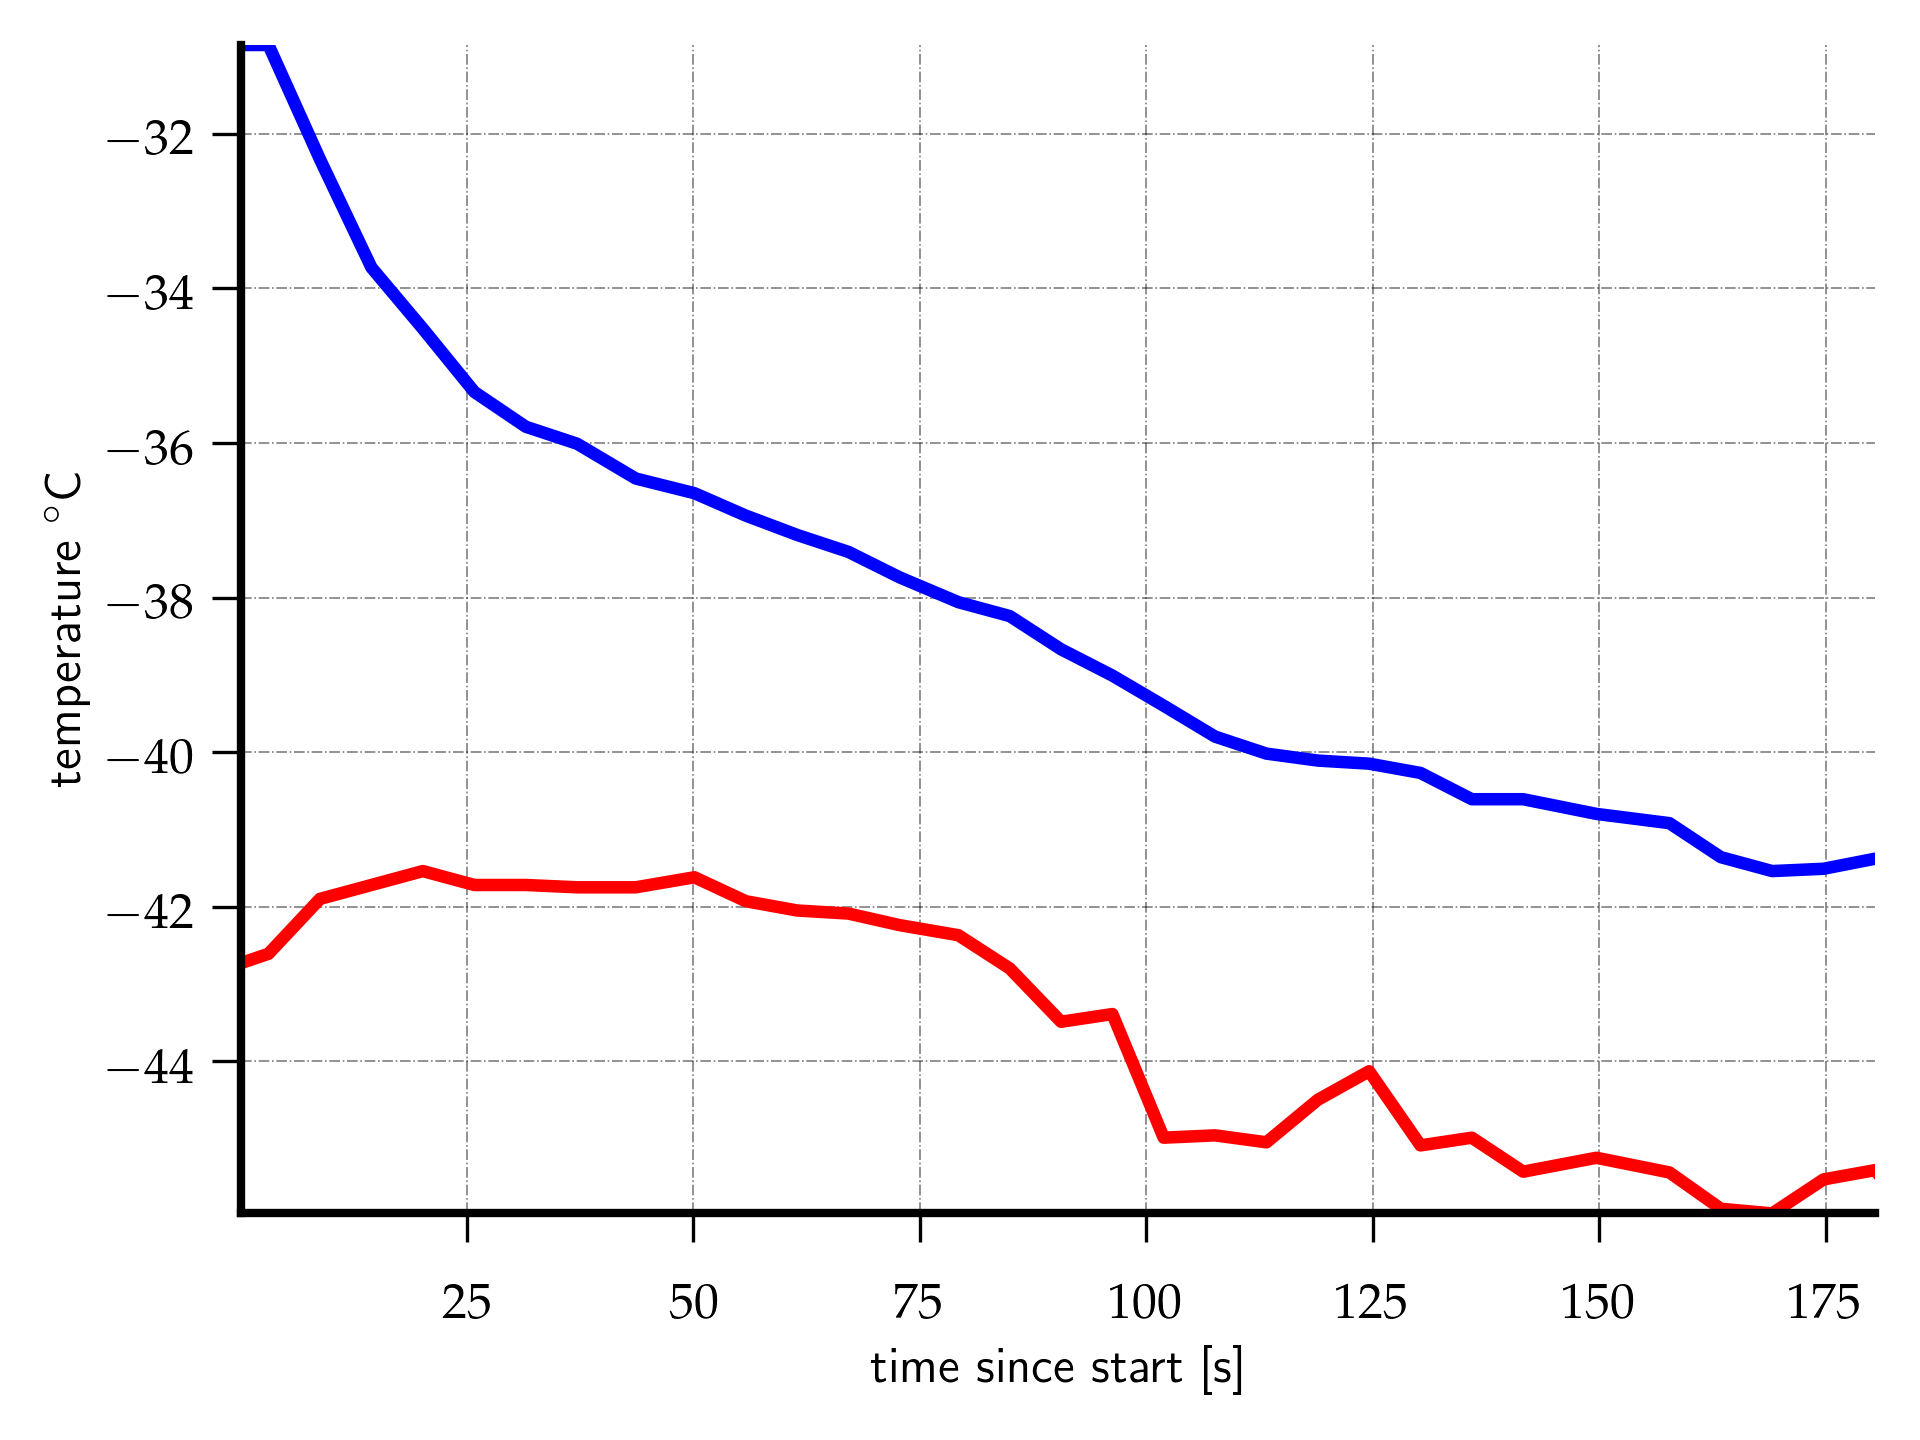

-46.21
-47
Reached target temperature


In [33]:
%matplotlib notebook

#cooldown
sunec.ON
sunec.monitor_temperatures(target_temp=-47,
                           activate=True)
#sunec.OFF

Turning on chamber...


<IPython.core.display.Javascript object>


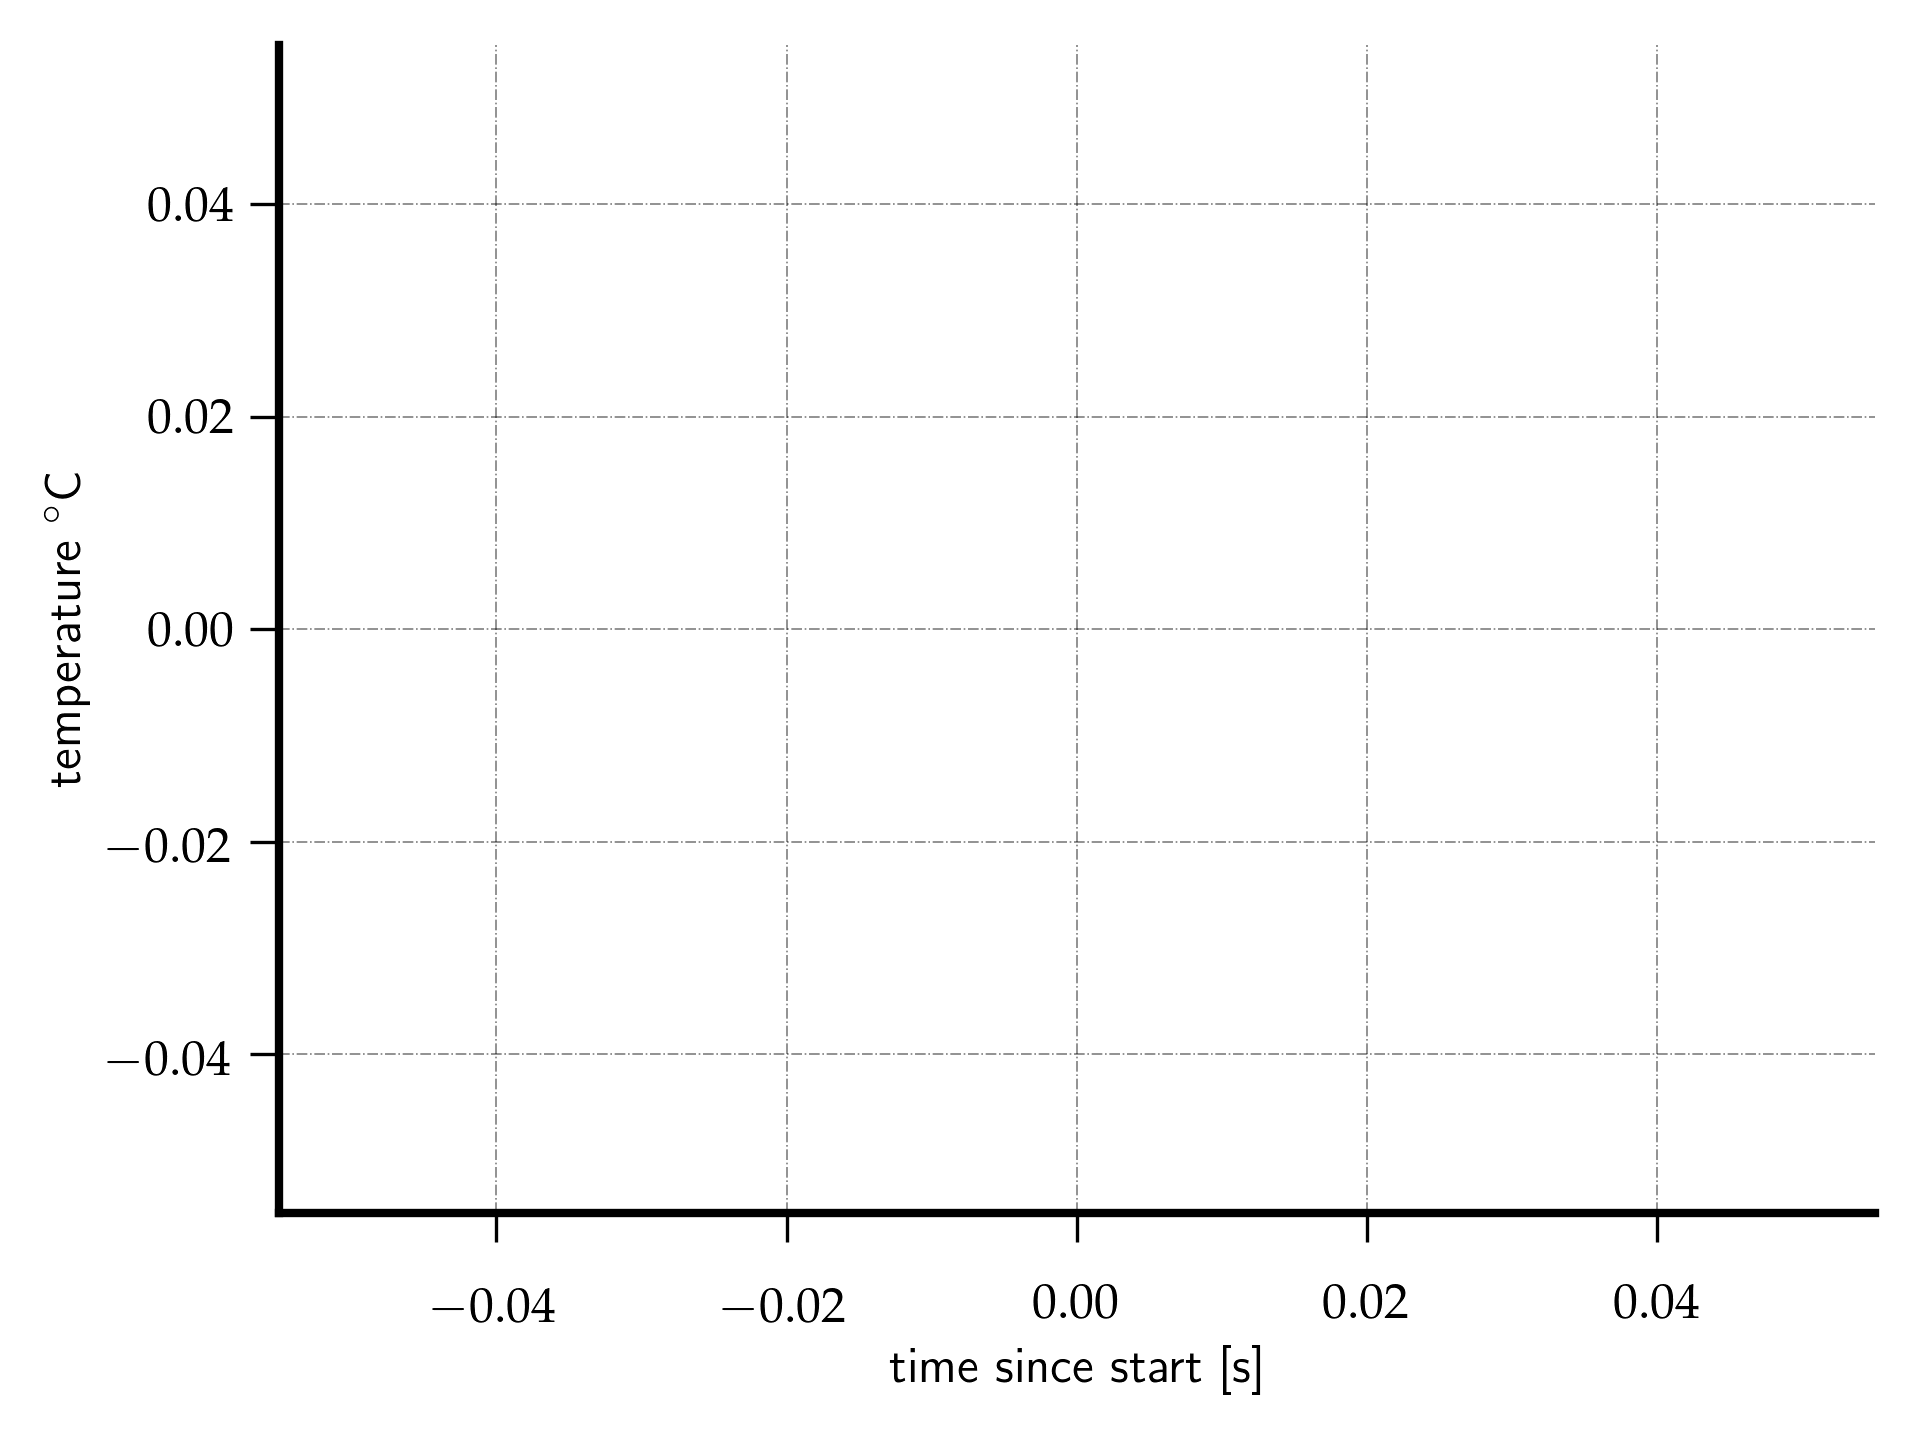

29.76
30
Reached target temperature


In [44]:
%matplotlib notebook

# warmup
sunec.ON
sunec.open_dry_nitrogen_valve()
sunec.close_dry_nitrogen_valve()
sunec.temperature_as_set = 30
sunec.monitor_temperatures(target_temp=30,
    activate=False)
#sunec.monitor_temperatures(target_temp=30,
#                           activate=True)
#sunec.OFF

### Try the oscilloscope as a DAQ

In [ ]:
import skippylab.instruments.oscilloscopes as osc

rs = osc.RhodeSchwarzRTO1044('192.168.1.6')
print(rs.ping())
rs.instrument.ask("*IDN?")

In [ ]:
rs.active_channel

In [ ]:
rs.ACQUIRE_ONE

In [ ]:
rs.acquire_waveform?

In [ ]:
rs.do_single_acquisition?

In [ ]:
rs.acquire_waveform()

In [ ]:
origin = rs.instrument.ask('CHANnel1:DATA:XORigin?')
xincre = rs.instrument.ask('CHANnel1:DATA:XINC?')
print (origin)
print (xincre)
alldata = []

In [ ]:
import tqdm
import pickle

for k in range(50):
    #sunec.OFF
    alldata = []
    for i in range(100):
        print(k,i)
        rs.instrument.write("RUNSingle")
        rs.instrument.write('ACQuire:NSINgle:COUNt 1')
        #time.sleep(1)
        while(True):

            finished = rs.instrument.ask('ACQuire:STATe?')
            #print(finished)
            time.sleep(0.2)
            if (finished == "COMP"):
                data = rs.instrument.ask("CHAN1:DATA?")
                #print (data[:12])
                alldata.append(data)
                break
            #if (finished == "STOP"):
           #     print ('stopped')
           #     try:
           #         data = rs.instrument.ask("CHAN1:DATA?")
           #         print (data[:12])
           #         alldata.append(data)
           #         break
           #     except Exception as e:
           #         print (e)
           #         continue

    datatosave = dict()
    datatosave['xorig'] = origin
    datatosave['xincr'] = xincre
    datatosave['volts'] = alldata
    try:
        filetosavepi = open(f'/home/achim/xray{k}.pickle', "xb")
    except:
        filetosavepi = open(f'/home/achim/xrayA{k}.pickle', 'xb')
    pickle.dump(datatosave, filetosavepi)
    filetosavepi.close()
    
    #delta_t = 0
    #start = time.monotonic()
    #sunec.ON
    #temp = sunec.get_temperature()
    #while (not (np.isfinite(temp))):
    #    temp = sunec.get_temperature()
    #while temp > -42:
    #    print (temp)
    #    sunec.ON
    #    sunec.activate_cooler()
    #    sunec.deactivate_heater()

    #    sunec.rate_as_set = 3
    #    sunec.temperature_as_set = -45
    #    time.sleep(20)
    #    temp = sunec.get_temperature()
    #    while (not (np.isfinite(temp))):
    #        temp = sunec.get_temperature()
    #sunec.OFF

In [ ]:
temp

In [ ]:
print (len(alldata))
import pickle
import hjson

datatosave = dict()
datatosave['xorig'] = origin
datatosave['xincr'] = xincre
datatosave['volts'] = alldata
filetosavepi = open('/home/achim/firstmuons.pickle', "xb")
filetosavehj = open('/home/achim/firstmuons.json', 'w')
hjson.dump(datatosave, filetosavehj)
pickle.dump(datatosave, filetosavepi)
filetosavepi.close()
filetosavehj.close()

In [ ]:
file = open()

In [ ]:
data = rs.instrument.ask("CHAN1:DATA?")